# Tutorial on Semi-Supervised Covariate Shift modelling using the Extended Joint Training Framework

This tutorial is intended to show the usage of the Extended Linear Joint Trained Framework (ExtJT) in a setting where a covariate shift has occurred between the source data (labelled) and the target data (unlabelled).


## Data
We will use a simulated dataset to illustrate the usage of ExtJT.
The data consist of three overlapping signals $S_1$, $S_2$ and $S_3$. The size of the signals is modelled in a three dimensional latent structure $z_1$, $z_2$ and $z_3$, where each of the latent dimensions are independent. We are interested in predicting $z_2$ based on the observed linear combination $z_1*S_1 + z_2*S_2 + z_3*S_3$.
In order to challenge the models, a covariate shift is simulated between the source and target domains. In the source domain $z_3$ is fixed at 3, while in the target domain $z_3$ is uniformly distributed between 3 and 4.


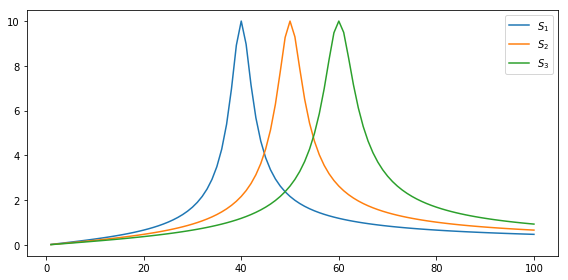

In [1]:
import numpy as np
from ExtJT.get_data import get_simulated_data
import matplotlib.pyplot as plt
from sklearn import preprocessing as pre
%matplotlib inline

data = get_simulated_data(seed=1234)
XTrain = data["Training"]["Spectra"]
XU = data["Unlabelled"]["Spectra"]
XTestS = data["Test Source"]["Spectra"]
XTestT = data["Test Target"]["Spectra"]

YTrain = data["Training"]["Noisy References"]
YTestS = data["Test Source"]["Noisy References"]
YTestT = data["Test Target"]["Noisy References"]
ZTest = data["Test Target"]["True References"]

f,ax = plt.subplots(1,1,figsize = (8,4))
ax.plot(data["Wavelength"],data["S"])
ax.legend([r"$S_1$",r"$S_2$",r"$S_3$"])
f.tight_layout();

## Data visualization
First, let's take a look at the data. There is a clear difference between the mean of instruments in the regions 600-750nm and 1700-1750. We could just avoid these regions when fitting our model, but we risk loosing chemical information when doing so. Instead we will use the Extended Joint Trained Framework to perform manifold regularization.

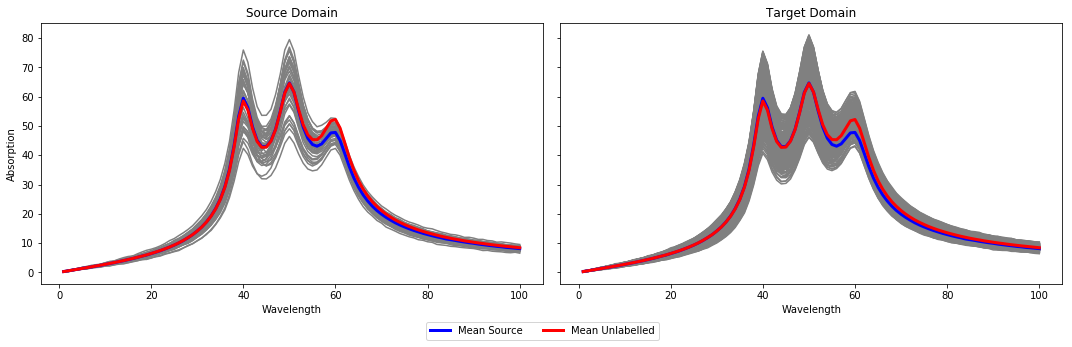

In [2]:
f,(ax1,ax2) = plt.subplots(1,2,figsize = (15,5),sharex=True,sharey=True)
ax1.set_title("Source Domain")
ax1.plot(data["Wavelength"],XTrain.T,c="gray",zorder=1)
ax1.plot(data["Wavelength"],XTrain.mean(axis=0),c="blue",zorder=2,label="Mean Source",lw=3)
ax1.plot(data["Wavelength"],XU.mean(axis=0),c="red",zorder=2,label="Mean Unlabelled",lw=3)
ax1.set_xlabel("Wavelength")
ax1.set_ylabel("Absorption")

ax2.set_title("Target Domain")
ax2.plot(data["Wavelength"],XU.T,c="gray",zorder=1)
ax2.plot(data["Wavelength"],XTrain.mean(axis=0),c="blue",zorder=2,label="Mean Source",lw=3)
ax2.plot(data["Wavelength"],XU.mean(axis=0),c="red",zorder=2,label="Mean Target",lw=3)
ax2.set_xlabel("Wavelength")

f.tight_layout()
f.subplots_adjust(bottom=0.2)
ax1.legend(ncol=2,loc='upper center', bbox_to_anchor=(1., -0.125));


## Fitting the Extended Linear Joint Trained Framework
We fit the Extended Linear Joint Trained Framework using PLS with up to 10 components on the labelled data from instrument 1 and the unlabelled data from instrument 2 with default parameters $\gamma_1=\gamma_3=1$ and $\gamma_2=1000$. As a reference we also fit a standard PLS to the labelled data from instrument 1. Both models are used to predict the validation samples from instrument 2.

In [3]:
from sklearn.cross_decomposition import PLSRegression as PLS
from ExtJT.ExtJT import ExtJTPLS,plsPREDICT
extJTPLS = ExtJTPLS(gamma1=1, gamma2=1000, gamma3=1, ncomp = 10, scale=False)
extJTPLS.fit(XTrain,YTrain,XU)
pls = PLS(n_components=10, scale=False)
pls.fit(XTrain,YTrain)

predsExtJT = extJTPLS.predict(XTestT)[1]
predsPLS = plsPREDICT(XTestT,pls)[1]

rmseExtJT = np.mean((predsExtJT.T-YTestT)**2,axis=1)**(1/2)
biasExtJT = np.mean((predsExtJT.T-YTestT),axis=1)
rmsePLS = np.mean((predsPLS.T-YTestT)**2,axis=1)**(1/2)
biasPLS = np.mean((predsPLS.T-YTestT),axis=1)


## Evaluation
We evaluate the models by plotting the RMSE and bias on the test data for ExtJT and PLS. We see that ExtJT is able the achieve a lower test error than PLS and that it is less prone to overfitting the training data, as it doesn't loose much performance when increasing the number of PLS components. Further we see that the reason behind PLS having a large error is a large bias. This observation is confirmed when the predictions and reference values are plotted together.

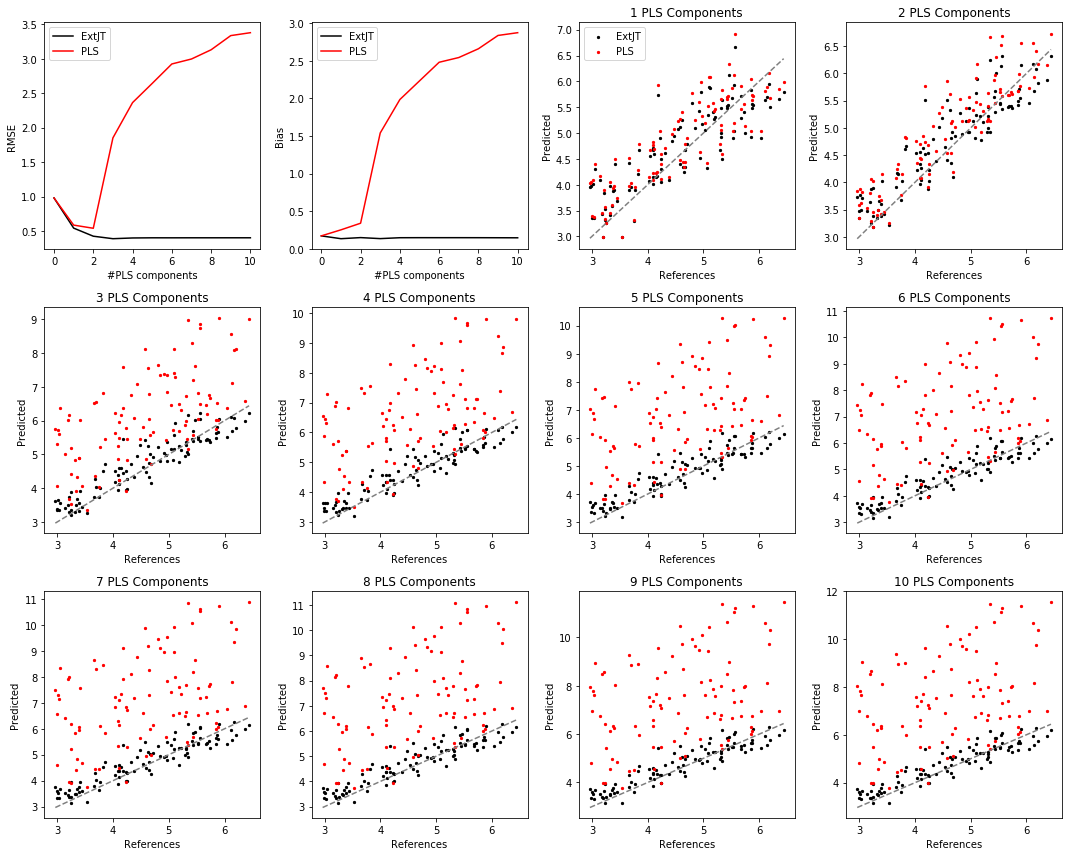

In [4]:
fig,ax = plt.subplots(3,4,figsize=(15,12))
ax = ax.flatten()
ax[0].plot(rmseExtJT, c="black", label="ExtJT")
ax[0].plot(rmsePLS, c="red", label="PLS")
ax[0].set_xlabel("#PLS components")
ax[0].set_ylabel("RMSE")
ax[0].legend()

ax[1].plot(biasExtJT, c="black", label="ExtJT")
ax[1].plot(biasPLS, c="red", label="PLS")
ax[1].set_xlabel("#PLS components")
ax[1].set_ylabel("Bias")
ax[1].legend()
for i in range(1,11):
    ax[i+1].scatter(YTestT,predsExtJT[:,i],s=5,c="black",label="ExtJT")
    ax[i+1].scatter(YTestT,predsPLS[:,i],s=5,c="red",label="PLS")
    ax[i+1].plot([YTestT.min(),YTestT.max()],[YTestT.min(),YTestT.max()],c="gray",ls="--")
    ax[i+1].set_xlabel("References")
    ax[i+1].set_ylabel("Predicted")
    ax[i+1].set_title(f"{i:d} PLS Components")
    if i == 1:
        ax[i+1].legend()
        
fig.tight_layout();

## What happens
Below we illustrate what happens when $\gamma_2$ is changed from a small to a large value. We vary $\gamma_2$ from $10^{-1}$ to $10^{5}$. For small values of $\gamma_2$ the parametrization of the singular values is pushed towards $\gamma_2$, and hence $X_U^{(\gamma_2)}$ is pushed towards the mean spectrum. For large values of $\gamma_2$ the parametrization of the singular values is pushed towards the original singular values. This mean that $X_U^{(\gamma_2)}$ converges to $X_U$.
In terms of manifold regularization, this mean that when $\gamma_2$ is small, the regularization is performed in the direction of the difference in mean values of the labelled and unlablled data. While for larger values of $\gamma_2$ the regularization converges towards the shape of $X_U$.

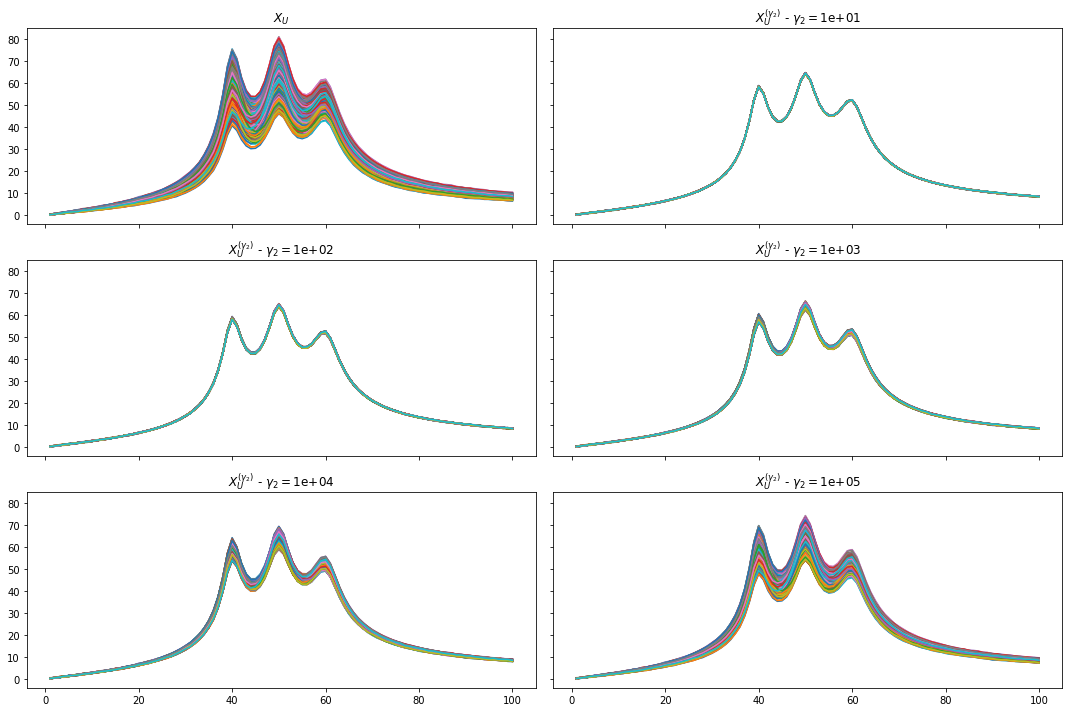

In [5]:
f,ax = plt.subplots(3,2,figsize = (15,10),sharex=True,sharey=True)
ax = ax.flatten()
ax[0].plot(data["Wavelength"],XU.T)
ax[0].set_title(r"$X_U$",fontsize=12)
Uu,Su,Vuh = np.linalg.svd(XU-XU.mean(axis=0),full_matrices=False)
Gamma2 = [1e1,1e2,1e3,1e4,1e5]
for i in range(5):
    gamma2 = Gamma2[i]
    XuGamma2 = gamma2**(1/2)*np.matmul(Uu*(Su**2+gamma2)**(-1/2)*Su,Vuh)+XU.mean(axis=0)
    ax[i+1].plot(data["Wavelength"],XuGamma2.T);
    ax[i+1].set_title(r"$X_U^{(\gamma_2)}$ - $\gamma_2 = $"+f"{gamma2:.0e}",fontsize=12);

f.tight_layout()

## Parameterization of singular values
In order to illustrate exactly how $X_U^{(\gamma_2)}$ converges to $X_U$, we will illustrate the path of the parameterization of the singular values. We see that, as expected, they all start at approximately the same value when $\gamma_2$ is small. When $\gamma_2$ is increased from a small value, the parameterization of large singular increases the most. Thus the variation in the data corresponding large singular values will be introduced before those corresponding to small singular values.

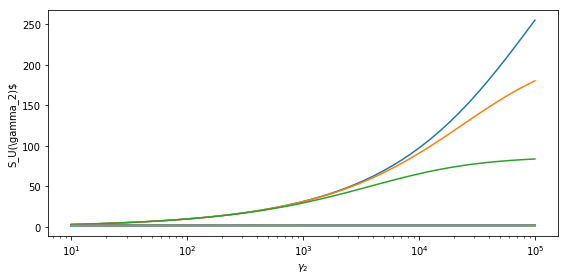

In [6]:
Uu,Su,Vuh = np.linalg.svd(XU-XU.mean(axis=0),full_matrices=False)
Gamma2 = [10**i for i in np.linspace(1,5,num=50)]
SuGamma2 = []
for i in range(len(Gamma2)):
    gamma2 = Gamma2[i]
    SuGamma2.append(gamma2**(1/2)*(Su**2+gamma2)**(-1/2)*Su)
SuGamma2 = np.array(SuGamma2)

f,ax = plt.subplots(1,1,figsize = (8,4))
ax.semilogx(Gamma2,SuGamma2[:,:20])
ax.set_xlabel(r"$\gamma_2$")
ax.set_ylabel(r"S_U(\gamma_2)$")
f.tight_layout();
